<a href="https://colab.research.google.com/github/luigiselmi/timeseries/blob/main/forecasting_with_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with Prophet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_url = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/daily_min_temp.csv'
df = pd.read_csv(data_url)
df.shape

(3650, 2)

In [3]:
df.head(1)

,Date,Temp
0,1981-01-01,20.7


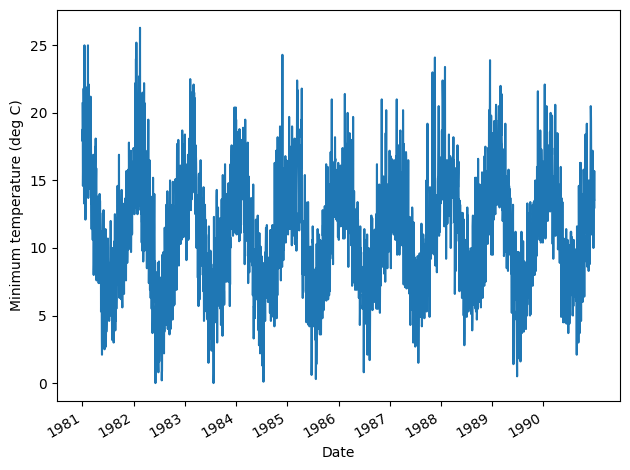

In [4]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(df['Temp'])
ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')
plt.xticks(np.arange(0, 3649, 365), np.arange(1981, 1991, 1))
plt.tight_layout()

In [5]:
df.columns = ['ds', 'y']
df.head(1)

,ds,y
0,1981-01-01,20.7


In [6]:
train = df[:-365]
test = df[-365:]

In [19]:
m = Prophet(daily_seasonality=True)

In [20]:
m.fit(train);

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkp3_x8pe/oqr73m3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkp3_x8pe/m9gvtnbd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25649', 'data', 'file=/tmp/tmpkp3_x8pe/oqr73m3n.json', 'init=/tmp/tmpkp3_x8pe/m9gvtnbd.json', 'output', 'file=/tmp/tmpkp3_x8pe/prophet_modelmeqohb94/prophet_model-20250310162736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
future = m.make_future_dataframe(periods=365)

In [22]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1981-01-01,18.933054,12.058324,18.728610,18.933054,18.933054,-3.608806,-3.608806,-3.608806,-7.001975,...,-0.026441,-0.026441,-0.026441,3.419610,3.419610,3.419610,0.0,0.0,0.0,15.324249
1,1981-01-02,18.931043,12.126393,19.136012,18.931043,18.931043,-3.529971,-3.529971,-3.529971,-7.001975,...,-0.009959,-0.009959,-0.009959,3.481963,3.481963,3.481963,0.0,0.0,0.0,15.401072
2,1981-01-03,18.929032,11.954391,18.916916,18.929032,18.929032,-3.508921,-3.508921,-3.508921,-7.001975,...,-0.048822,-0.048822,-0.048822,3.541876,3.541876,3.541876,0.0,0.0,0.0,15.420112
3,1981-01-04,18.927021,12.067292,18.948251,18.927021,18.927021,-3.592108,-3.592108,-3.592108,-7.001975,...,-0.188694,-0.188694,-0.188694,3.598561,3.598561,3.598561,0.0,0.0,0.0,15.334913
4,1981-01-05,18.925010,12.152320,19.114427,18.925010,18.925010,-3.307060,-3.307060,-3.307060,-7.001975,...,0.043619,0.043619,0.043619,3.651296,3.651296,3.651296,0.0,0.0,0.0,15.617951


In [23]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-365:-360]

,ds,yhat,yhat_lower,yhat_upper
3285,1990-01-01,14.865526,11.464655,18.190687
3286,1990-01-02,14.991817,11.651515,18.386756
3287,1990-01-03,15.068052,11.642375,18.391398
3288,1990-01-04,14.975956,11.472822,18.595111
3289,1990-01-05,15.046056,11.485693,18.564973


In [24]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
3285,1990-01-01,14.8,14.865526,11.464655,18.190687,14.3
3286,1990-01-02,13.3,14.991817,11.651515,18.386756,17.4
3287,1990-01-03,15.6,15.068052,11.642375,18.391398,18.5
3288,1990-01-04,14.5,14.975956,11.472822,18.595111,16.8
3289,1990-01-05,14.3,15.046056,11.485693,18.564973,11.5


In [25]:
test['baseline'] = train['y'][-365:].values

In [26]:
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])
print('Model MAE: {:.2f}'.format(prophet_mae))
print('Baseline MAE: {:.2f}'.format(baseline_mae))

Model MAE: 1.94
Baseline MAE: 2.87


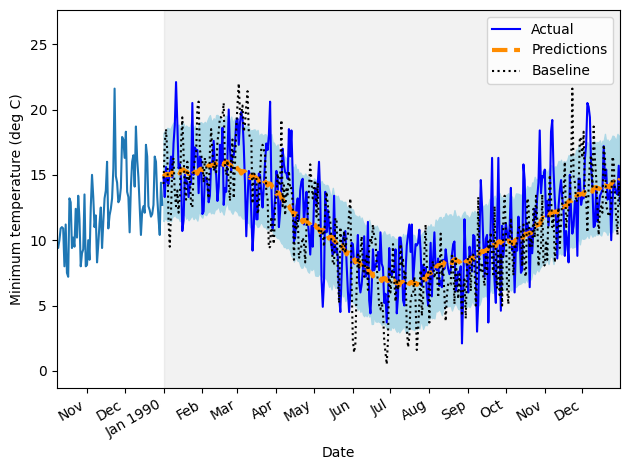

In [27]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')
ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')
ax.axvspan(3285, 3649, color='#808080', alpha=0.1)
ax.legend(loc='best')

plt.xticks(
    [3224, 3254, 3285, 3316, 3344, 3375, 3405, 3436, 3466, 3497, 3528, 3558, 3589, 3619],
    ['Nov', 'Dec', 'Jan 1990', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(3200, 3649)
plt.tight_layout()